# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries as needed
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from itertools import accumulate
from pylab import rcParams
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# sagemaker libraries
import pickle
import os

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
%%time

# fix some options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
rcParams['agg.path.chunksize'] = 10000

CPU times: user 70 µs, sys: 6 µs, total: 76 µs
Wall time: 79.6 µs


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
%%time
# load in the data
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

CPU times: user 5.47 s, sys: 919 ms, total: 6.39 s
Wall time: 7.18 s


In [4]:
%%time
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)

CPU times: user 34.3 s, sys: 3.97 s, total: 38.3 s
Wall time: 42.3 s


In [5]:
%%time

customersCopy = customers.copy()
azdiasCopy = azdias.copy()

CPU times: user 541 ms, sys: 538 ms, total: 1.08 s
Wall time: 1.08 s


In [ ]:
%%time

#customers = customersCopy.copy()
#azdias = azdiasCopy.copy()

In [6]:
%%time
## Write/Read to pickle file

cacheDir = os.path.join("./cache", "arvato_segmentation")  # where to store cache files
os.makedirs(cacheDir, exist_ok=True)  # ensure cache directory exists

def writeToPickle(df, fileName):
    '''
    Write the dataframe to the disk using the given file name and global path defined (cacheDir) 
    
    INPUT: 
        df: DataFrame
        fileName: fileName to write to (no extension required)
    '''
    print('WriteToPickle: ', fileName)
    cachePath = os.path.join(cacheDir, fileName + '.pkl')
    df.to_pickle(cachePath)
    
def readFromPickle(fileName):
    '''
    Read the dataframe from the disk using the given file name and global path defined (cacheDir) 
    
    INPUT: 
        fileName: fileName to read from (no extension required)
        
    OUTPUT:
        Data read from the file as a dataframe
    '''
    print('ReadFromPickle: ', fileName)
    cachePath = os.path.join(cacheDir, fileName + '.pkl')
    df = pd.read_pickle(cachePath)
    return df
    
def writeAzdiasCustomersToPickle():
    '''
    Read the dataframe from the disk using the given file name and global path defined (cacheDir) 
    
    INPUT: 
        fileName: fileName to read from (no extension required)
        
    OUTPUT:
        Data read from the file as a dataframe
    '''
    writeToPickle(azdiasCopy, 'azdias')
    writeToPickle(customersCopy, 'customers')    

def readAzdiasCustomersFromPickle():
    '''
    Read the Azdias and Customers dataframe from the disk. This is a wrapper function.

    OUTPUT:
        Data read from the files as a two dataframes (Azdias and Customers)
    '''
    azdias = readFromPickle("azdias")
    customers = readFromPickle("customers")
    return (azdias, customers)

def writeScaledAzdiasCustomersToPickle():
    '''
    Write the Azdias and Customers dataframe to the disk. This is a wrapper function. 
    '''
    writeToPickle(scaledAzdias, 'scaledAzdias')
    writeToPickle(scaledCustomers, 'scaledCustomers')    

def readScaledAzdiasCustomersFromPickle():
    '''
    Read the dataframe from the disk using the given file name and global path defined (cacheDir) 
        
    OUTPUT:
        Data read from the files as two dataframes (scaledAzdias and scaledCustomers)
    '''
    scaledAzdias = readFromPickle("scaledAzdias")
    scaledCustomers = readFromPickle("scaledCustomers")
    return (azdias, customers)

CPU times: user 875 µs, sys: 0 ns, total: 875 µs
Wall time: 571 µs


In [22]:
%%time
## Write to the pickle file

#writeAzdiasCustomersToPickle()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


In [4]:
%%time
## Read from pickle file

(azdiasCopy, customersCopy) = readAzdiasCustomersFromPickle()

print(azdiasCopy.shape)
print(customersCopy.shape)

ReadFromPickle:  azdias
ReadFromPickle:  customers
(785421, 302)
(140371, 302)
CPU times: user 1.47 s, sys: 2.15 s, total: 3.61 s
Wall time: 5min 15s


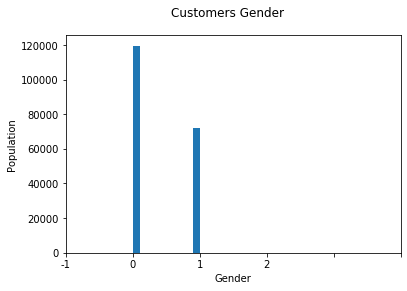

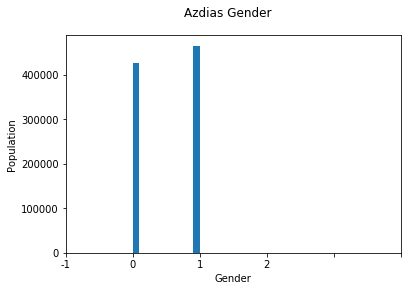

CPU times: user 317 ms, sys: 8.43 ms, total: 325 ms
Wall time: 506 ms


In [7]:
%%time 

## draw histograms for data

columnName = 'ANREDE_KZ'
xLabelName = 'Population'
xTickString = ['-1', '0', '1', '2']
arrangeData = 6
xLabel = 'Gender'
yLabel = 'Population'

###

plt.hist(customersCopy[columnName].values)
plt.xticks(np.arange(arrangeData), xTickString) # Set text labels.
plt.suptitle('Customers Gender')
plt.xlabel(xLabel)
plt.ylabel(yLabel)
plt.show()

###

plt.hist(azdiasCopy[columnName].values)
plt.xticks(np.arange(arrangeData), xTickString) # Set text labels.
plt.suptitle('Azdias Gender')
plt.xlabel(xLabel)
plt.ylabel(yLabel)
plt.show()


In [8]:
%%time

print('Azdias')
print(azdiasCopy.describe())
print('Customers')
print(customersCopy.describe())

Azdias
                LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   
std        4.097660      3.243300     2.712427     2.452932   
min        2.000000      2.000000     4.000000     7.000000   
25%        8.000000     11.000000    13.000000    14.000000   
50

In [9]:
# Data Cleanup

## 1. convert all the missing values to nan
## 1.1 create a dictionary of all key value pairs for missing values per attribute
missingValuesDictionary = {
    'AGER_TYP' : ['-1'], # unknown
    'ALTERSKATEGORIE_GROB' : ['-1', '0'], # unknown
    'ALTER_HH' : ['0'], # unknown
    'ANREDE_KZ' : ['-1', '0'], # unknown
    'BALLRAUM' : ['-1'], # unknown
    'BIP_FLAG' : ['-1'], # unknown
    'CAMEO_DEUG_2015' : ['-1', 'XX', 'X'], # unknown
    'CAMEO_DEUINTL_2015' : ['-1'], # unknown
    'CAMEO_INTL_2015' : ['XX', 'X'], # unknown
    'CJT_GESAMTTYP' : ['0'], # unknown
    #'D19_BANKEN_ANZ_12' : ['0'], # not known
    #'D19_BANKEN_ANZ_24' : ['0'], # not known
    #'D19_BANKEN_DATUM' : ['10'], # not known
    #'D19_BANKEN_DIREKT_RZ' : ['0'], # not known
    #'D19_BANKEN_GROSS_RZ' : ['0'], # not known
    #'D19_BANKEN_LOKAL_RZ' : ['0'], # not known
    #'D19_BANKEN_OFFLINE_DATUM' : ['10'], # not known
    #'D19_BANKEN_ONLINE_DATUM' : ['10'], # not known
    #'D19_BANKEN_ONLINE_QUOTE_12' : ['0'], # none
    #'D19_BANKEN_REST_RZ' : ['0'], # not known
    #'D19_BEKLEIDUNG_GEH_RZ' : ['0'], # not known
    #'D19_BEKLEIDUNG_REST_RZ' : ['0'], # not known
    #'D19_BILDUNG_RZ' : ['0'], # not known
    #'D19_BIO_OEKO_RZ' : ['0'], # not known
    #'D19_BUCH_RZ' : ['0'], # not known
    #'D19_DIGIT_SERV_RZ' : ['0'], # not known
    #'D19_DROGERIEARTIKEL_RZ' : ['0'], # not known
    #'D19_ENERGIE_RZ' : ['0'], # not known
    #'D19_FREIZEIT_RZ' : ['0'], # not known
    #'D19_GARTEN_RZ' : ['0'], # not known
    #'D19_GESAMT_ANZ_12' : ['0'], # not known
    #'D19_GESAMT_ANZ_24' : ['0'], # not known
    #'D19_GESAMT_DATUM' : ['10'], # not known
    #'D19_GESAMT_OFFLINE_DATUM' : ['10'], # not known
    #'D19_GESAMT_ONLINE_DATUM' : ['10'], # not known
    #'D19_GESAMT_ONLINE_QUOTE_12' : ['0'], # not known
    #'D19_HANDWERK_RZ' : ['0'], # not known
    #'D19_HAUS_DEKO_RZ' : ['0'], # not known
    #'D19_KINDERARTIKEL_RZ' : ['0'], # not known
    #'D19_KK_KUNDENTYP' : ['-1'], # unknown
    #'D19_KONSUMTYP' : ['9'], #inactive, consumption type
    #'D19_KOSMETIK_RZ' : ['0'], # not known
    #'D19_LEBENSMITTEL_RZ' : ['0'], # not known
    #'D19_LOTTO_RZ' : ['0'], # not known
    #'D19_NAHRUNGSERGAENZUNG_RZ' : ['0'], # not known
    #'D19_RATGEBER_RZ' : ['0'], # not known
    #'D19_REISEN_RZ' : ['0'], # not known
    #'D19_SAMMELARTIKEL_RZ' : ['0'], # not known
    #'D19_SCHUHE_RZ' : ['0'], # not known
    #'D19_SONSTIGE_RZ' : ['0'], # not known
    #'D19_TECHNIK_RZ' : ['0'], # not known
    #'D19_TELKO_ANZ_12' : ['0'], # not known
    #'D19_TELKO_ANZ_24' : ['0'], # not known
    #'D19_TELKO_DATUM' : ['10'], # not known
    #'D19_TELKO_MOBILE_RZ' : ['0'], # not known
    #'D19_TELKO_OFFLINE_DATUM' : ['10'], # not known
    #'D19_TELKO_ONLINE_DATUM' : ['10'], # not known
    #'D19_TELKO_REST_RZ' : ['0'], # not known
    #'D19_TIERARTIKEL_RZ' : ['0'], # not known
    #'D19_VERSAND_ANZ_12' : ['0'], # not known
    #'D19_VERSAND_ANZ_24' : ['0'], # not known
    #'D19_VERSAND_DATUM' : ['10'], # not known
    #'D19_VERSAND_OFFLINE_DATUM' : ['10'], # not known
    #'D19_VERSAND_ONLINE_DATUM' : ['10'], # not known
    #'D19_VERSAND_ONLINE_QUOTE_12' : ['0'], #none
    #'D19_VERSAND_REST_RZ' : ['0'], # not known
    #'D19_VERSICHERUNGEN_RZ' : ['0'], # not known
    #'D19_VERSI_ANZ_12' : ['0'], # not known
    #'D19_VERSI_ANZ_24' : ['0'], # not known
    #'D19_VOLLSORTIMENT_RZ' : ['0'], # not known
    #'D19_WEIN_FEINKOST_RZ' : ['0'], # not known
    'EWDICHTE' : ['-1'], # unknown
    'FINANZTYP' : ['-1'], # unknown
    'FINANZ_ANLEGER' : ['-1'], # unknown
    'FINANZ_HAUSBAUER' : ['-1'], # unknown
    'FINANZ_MINIMALIST' : ['-1'], # unknown
    'FINANZ_SPARER' : ['-1'], # unknown
    'FINANZ_UNAUFFAELLIGER' : ['-1'], # unknown
    'FINANZ_VORSORGER' : ['-1'], # unknown
    'GEBAEUDETYP' : ['-1', '0'], # unknown
    'GEBURTSJAHR' : ['0'],
    'GEOSCORE_KLS7' : ['-1', '0'], # unknown
    'HAUSHALTSSTRUKTUR' : ['-1', '0'], # unknown
    'HEALTH_TYP' : ['-1'], # unknown
    'HH_EINKOMMEN_SCORE' : ['-1', '0'], # unknown
    'INNENSTADT' : ['-1'], # unknown
    'KBA05_ALTER1' : ['-1', '9'], # unknown
    'KBA05_ALTER2' : ['-1', '9'], # unknown
    'KBA05_ALTER3' : ['-1', '9'], # unknown
    'KBA05_ALTER4' : ['-1', '9'], # unknown
    'KBA05_ANHANG' : ['-1', '9'], # unknown
    'KBA05_ANTG1' : ['-1'], # unknown
    'KBA05_ANTG2' : ['-1'], # unknown
    'KBA05_ANTG3' : ['-1'], # unknown
    'KBA05_ANTG4' : ['-1'], # unknown
    'KBA05_AUTOQUOT' : ['-1', '9'], # unknown
    'KBA05_BAUMAX' : ['-1', '0'], # unknown
    'KBA05_CCM1' : ['-1', '9'], # unknown
    'KBA05_CCM2' : ['-1', '9'], # unknown
    'KBA05_CCM3' : ['-1', '9'], # unknown
    'KBA05_CCM4' : ['-1', '9'], # unknown
    'KBA05_DIESEL' : ['-1', '9'], # unknown
    'KBA05_FRAU' : ['-1', '9'], # unknown
    'KBA05_GBZ' : ['-1', '0'], # unknown
    'KBA05_HERST1' : ['-1', '9'], # unknown
    'KBA05_HERST2' : ['-1', '9'], # unknown
    'KBA05_HERST3' : ['-1', '9'], # unknown
    'KBA05_HERST4' : ['-1', '9'], # unknown
    'KBA05_HERST5' : ['-1', '9'], # unknown
    'KBA05_HERSTTEMP' : ['-1', '9'], # unknown
    'KBA05_KRSAQUOT' : ['-1', '9'], # unknown
    'KBA05_KRSHERST1' : ['-1', '9'], # unknown
    'KBA05_KRSHERST2' : ['-1', '9'], # unknown
    'KBA05_KRSHERST3' : ['-1', '9'], # unknown
    'KBA05_KRSKLEIN' : ['-1', '9'], # unknown
    'KBA05_KRSOBER' : ['-1', '9'], # unknown
    'KBA05_KRSVAN' : ['-1', '9'], # unknown
    'KBA05_KRSZUL' : ['-1', '9'], # unknown
    'KBA05_KW1' : ['-1', '9'], # unknown
    'KBA05_KW2' : ['-1', '9'], # unknown
    'KBA05_KW3' : ['-1', '9'], # unknown
    'KBA05_MAXAH' : ['-1', '9'], # unknown
    'KBA05_MAXBJ' : ['-1', '9'], # unknown
    'KBA05_MAXHERST' : ['-1', '9'], # unknown
    'KBA05_MAXSEG' : ['-1', '9'], # unknown
    'KBA05_MAXVORB' : ['-1', '9'], # unknown
    'KBA05_MOD1' : ['-1', '9'], # unknown
    'KBA05_MOD2' : ['-1', '9'], # unknown
    'KBA05_MOD3' : ['-1', '9'], # unknown
    'KBA05_MOD4' : ['-1', '9'], # unknown
    'KBA05_MOD8' : ['-1', '9'], # unknown
    'KBA05_MODTEMP' : ['-1', '9'], # unknown
    'KBA05_MOTOR' : ['-1', '9'], # unknown
    'KBA05_MOTRAD' : ['-1', '9'], # unknown
    'KBA05_SEG1' : ['-1', '9'], # unknown
    'KBA05_SEG10' : ['-1', '9'], # unknown
    'KBA05_SEG2' : ['-1', '9'], # unknown
    'KBA05_SEG3' : ['-1', '9'], # unknown
    'KBA05_SEG4' : ['-1', '9'], # unknown
    'KBA05_SEG5' : ['-1', '9'], # unknown
    'KBA05_SEG6' : ['-1', '9'], # unknown
    'KBA05_SEG7' : ['-1', '9'], # unknown
    'KBA05_SEG8' : ['-1', '9'], # unknown
    'KBA05_SEG9' : ['-1', '9'], # unknown
    'KBA05_VORB0' : ['-1', '9'], # unknown
    'KBA05_VORB1' : ['-1', '9'], # unknown
    'KBA05_VORB2' : ['-1', '9'], # unknown
    'KBA05_ZUL1' : ['-1', '9'], # unknown
    'KBA05_ZUL2' : ['-1', '9'], # unknown
    'KBA05_ZUL3' : ['-1', '9'], # unknown
    'KBA05_ZUL4' : ['-1', '9'], # unknown
    'KBA13_ALTERHALTER_30' : ['-1'], # unknown
    'KBA13_ALTERHALTER_45' : ['-1'], # unknown
    'KBA13_ALTERHALTER_60' : ['-1'], # unknown
    'KBA13_ALTERHALTER_61' : ['-1'], # unknown
    'KBA13_AUDI' : ['-1'], # unknown
    'KBA13_AUTOQUOTE' : ['-1'], # unknown
    'KBA13_BJ_1999' : ['-1'], # unknown
    'KBA13_BJ_2000' : ['-1'], # unknown
    'KBA13_BJ_2004' : ['-1'], # unknown
    'KBA13_BJ_2006' : ['-1'], # unknown
    'KBA13_BJ_2008' : ['-1'], # unknown
    'KBA13_BJ_2009' : ['-1'], # unknown
    'KBA13_BMW' : ['-1'], # unknown
    'KBA13_CCM_0_1400' : ['-1'], # unknown
    'KBA13_CCM_1000' : ['-1'], # unknown
    'KBA13_CCM_1200' : ['-1'], # unknown
    'KBA13_CCM_1400' : ['-1'], # unknown
    'KBA13_CCM_1400_2500' : ['-1'], # unknown
    'KBA13_CCM_1500' : ['-1'], # unknown
    'KBA13_CCM_1600' : ['-1'], # unknown
    'KBA13_CCM_1800' : ['-1'], # unknown
    'KBA13_CCM_2000' : ['-1'], # unknown
    'KBA13_CCM_2500' : ['-1'], # unknown
    'KBA13_CCM_2501' : ['-1'], # unknown
    'KBA13_CCM_3000' : ['-1'], # unknown
    'KBA13_CCM_3001' : ['-1'], # unknown
    'KBA13_FAB_ASIEN' : ['-1'], # unknown
    'KBA13_FAB_SONSTIGE' : ['-1'], # unknown
    'KBA13_FIAT' : ['-1'], # unknown
    'KBA13_FORD' : ['-1'], # unknown
    'KBA13_HALTER_20' : ['-1'], # unknown
    'KBA13_HALTER_25' : ['-1'], # unknown
    'KBA13_HALTER_30' : ['-1'], # unknown
    'KBA13_HALTER_35' : ['-1'], # unknown
    'KBA13_HALTER_40' : ['-1'], # unknown
    'KBA13_HALTER_45' : ['-1'], # unknown
    'KBA13_HALTER_50' : ['-1'], # unknown
    'KBA13_HALTER_55' : ['-1'], # unknown
    'KBA13_HALTER_60' : ['-1'], # unknown
    'KBA13_HALTER_65' : ['-1'], # unknown
    'KBA13_HALTER_66' : ['-1'], # unknown
    'KBA13_HERST_ASIEN' : ['-1'], # unknown
    'KBA13_HERST_AUDI_VW' : ['-1'], # unknown
    'KBA13_HERST_BMW_BENZ' : ['-1'], # unknown
    'KBA13_HERST_EUROPA' : ['-1'], # unknown
    'KBA13_HERST_FORD_OPEL' : ['-1'], # unknown
    'KBA13_HERST_SONST' : ['-1'], # unknown
    'KBA13_KMH_0_140' : ['-1'], # unknown
    'KBA13_KMH_110' : ['-1'], # unknown
    'KBA13_KMH_140' : ['-1'], # unknown
    'KBA13_KMH_140_210' : ['-1'], # unknown
    'KBA13_KMH_180' : ['-1'], # unknown
    'KBA13_KMH_211' : ['-1'], # unknown
    'KBA13_KMH_250' : ['-1'], # unknown
    'KBA13_KMH_251' : ['-1'], # unknown
    'KBA13_KRSAQUOT' : ['-1'], # unknown
    'KBA13_KRSHERST_AUDI_VW' : ['-1'], # unknown
    'KBA13_KRSHERST_BMW_BENZ' : ['-1'], # unknown
    'KBA13_KRSHERST_FORD_OPEL' : ['-1'], # unknown
    'KBA13_KRSSEG_KLEIN' : ['-1'], # unknown
    'KBA13_KRSSEG_OBER' : ['-1'], # unknown
    'KBA13_KRSSEG_VAN' : ['-1'], # unknown
    'KBA13_KRSZUL_NEU' : ['-1'], # unknown
    'KBA13_KW_0_60' : ['-1'], # unknown
    'KBA13_KW_110' : ['-1'], # unknown
    'KBA13_KW_120' : ['-1'], # unknown
    'KBA13_KW_121' : ['-1'], # unknown
    'KBA13_KW_30' : ['-1'], # unknown
    'KBA13_KW_40' : ['-1'], # unknown
    'KBA13_KW_50' : ['-1'], # unknown
    'KBA13_KW_60' : ['-1'], # unknown
    'KBA13_KW_61_120' : ['-1'], # unknown
    'KBA13_KW_70' : ['-1'], # unknown
    'KBA13_KW_80' : ['-1'], # unknown
    'KBA13_KW_90' : ['-1'], # unknown
    'KBA13_MAZDA' : ['-1'], # unknown
    'KBA13_MERCEDES' : ['-1'], # unknown
    'KBA13_MOTOR' : ['-1'], # unknown
    'KBA13_NISSAN' : ['-1'], # unknown
    'KBA13_OPEL' : ['-1'], # unknown
    'KBA13_PEUGEOT' : ['-1'], # unknown
    'KBA13_RENAULT' : ['-1'], # unknown
    'KBA13_SEG_GELAENDEWAGEN' : ['-1'], # unknown
    'KBA13_SEG_GROSSRAUMVANS' : ['-1'], # unknown
    'KBA13_SEG_KLEINST' : ['-1'], # unknown
    'KBA13_SEG_KLEINWAGEN' : ['-1'], # unknown
    'KBA13_SEG_KOMPAKTKLASSE' : ['-1'], # unknown
    'KBA13_SEG_MINIVANS' : ['-1'], # unknown
    'KBA13_SEG_MINIWAGEN' : ['-1'], # unknown
    'KBA13_SEG_MITTELKLASSE' : ['-1'], # unknown
    'KBA13_SEG_OBEREMITTELKLASSE' : ['-1'], # unknown
    'KBA13_SEG_OBERKLASSE' : ['-1'], # unknown
    'KBA13_SEG_SONSTIGE' : ['-1'], # unknown
    'KBA13_SEG_SPORTWAGEN' : ['-1'], # unknown
    'KBA13_SEG_UTILITIES' : ['-1'], # unknown
    'KBA13_SEG_VAN' : ['-1'], # unknown
    'KBA13_SEG_WOHNMOBILE' : ['-1'], # unknown
    'KBA13_SITZE_4' : ['-1'], # unknown
    'KBA13_SITZE_5' : ['-1'], # unknown
    'KBA13_SITZE_6' : ['-1'], # unknown
    'KBA13_TOYOTA' : ['-1'], # unknown
    'KBA13_VORB_0' : ['-1'], # unknown
    'KBA13_VORB_1' : ['-1'], # unknown
    'KBA13_VORB_1_2' : ['-1'], # unknown
    'KBA13_VORB_2' : ['-1'], # unknown
    'KBA13_VORB_3' : ['-1'], # unknown
    'KBA13_VW' : ['-1'], # unknown
    'KKK' : ['-1', '0'], # unknown
    'MOBI_REGIO' : ['0'], # none
    'NATIONALITAET_KZ' : ['-1', '0'], # unknown
    'ONLINE_AFFINITAET' : ['0'], # none
    'ORTSGR_KLS9' : ['-1'], # unknown
    'OST_WEST_KZ' : ['-1'], # unknown
    'PLZ8_ANTG1' : ['-1'], # unknown
    'PLZ8_ANTG2' : ['-1'], # unknown
    'PLZ8_ANTG3' : ['-1'], # unknown
    'PLZ8_ANTG4' : ['-1'], # unknown
    'PLZ8_GBZ' : ['-1'], # unknown
    'PLZ8_HHZ' : ['-1'], # unknown
    'PRAEGENDE_JUGENDJAHRE' : ['-1', '0'], # unknown
    'REGIOTYP' : ['-1', '0'], # unknown
    'RELAT_AB' : ['-1', '9'], # unknown
    'RETOURTYP_BK_S' : ['0'], # unknown
    'SEMIO_DOM' : ['-1', '9'], # unknown
    'SEMIO_ERL' : ['-1', '9'], # unknown
    'SEMIO_FAM' : ['-1', '9'], # unknown
    'SEMIO_KAEM' : ['-1', '9'], # unknown
    'SEMIO_KRIT' : ['-1', '9'], # unknown
    'SEMIO_KULT' : ['-1', '9'], # unknown
    'SEMIO_LUST' : ['-1', '9'], # unknown
    'SEMIO_MAT' : ['-1', '9'], # unknown
    'SEMIO_PFLICHT' : ['-1', '9'], # unknown
    'SEMIO_RAT' : ['-1', '9'], # unknown
    'SEMIO_REL' : ['-1', '9'], # unknown
    'SEMIO_SOZ' : ['-1', '9'], # unknown
    'SEMIO_TRADV' : ['-1', '9'], # unknown
    'SEMIO_VERT' : ['-1', '9'], # unknown
    'SHOPPER_TYP' : ['-1'], # unknown
    'SOHO_FLAG' : ['-1'], # unknown
    'TITEL_KZ' : ['-1', '0'], # unknown
    'VERS_TYP' : ['-1'], # unknown
    'WACHSTUMSGEBIET_NB' : ['-1', '0'], # unknown
    'WOHNDAUER_2008' : ['-1', '0'], # unknown
    'WOHNLAGE' : ['-1'], # unknown
    'W_KEIT_KIND_HH' : ['-1', '0'], # unknown
    'ZABEOTYP' : ['-1', '9'] # unknown
}

def CleanDataBymarkingNaN(df):
    '''
    Clean the dataframe by swapping unknown values for NaN 
    
    INPUT: 
        df: Dataframe to clean
        
    OUTPUT:
        Cleaned dataframe
    '''
    print('CleanDataBymarkingNaN')
    ## 1.2 Swap unknown values with Nan
    i = 0
    for (columnName, columnValues) in missingValuesDictionary.items():
        i += 1
        print(i, 'column header: ', columnName)
        for value in columnValues:
            try:
                df.loc[df[columnName] == int(value), columnName] = np.nan
            except:
                print('value not found: ', value)
    return df

In [10]:
%%time
## Clean data by marking as NaN

customersCopy = CleanDataBymarkingNaN(customersCopy)
print(customersCopy.shape)
customersCopy.describe()

CleanDataBymarkingNaN
1 column header:  AGER_TYP
2 column header:  ALTERSKATEGORIE_GROB
3 column header:  ALTER_HH
4 column header:  ANREDE_KZ
5 column header:  BALLRAUM
6 column header:  BIP_FLAG
value not found:  -1
7 column header:  CAMEO_DEUG_2015
value not found:  XX
value not found:  X
8 column header:  CAMEO_DEUINTL_2015
value not found:  -1
9 column header:  CAMEO_INTL_2015
value not found:  XX
value not found:  X
10 column header:  CJT_GESAMTTYP
11 column header:  EWDICHTE
12 column header:  FINANZTYP
13 column header:  FINANZ_ANLEGER
14 column header:  FINANZ_HAUSBAUER
15 column header:  FINANZ_MINIMALIST
16 column header:  FINANZ_SPARER
17 column header:  FINANZ_UNAUFFAELLIGER
18 column header:  FINANZ_VORSORGER
19 column header:  GEBAEUDETYP
20 column header:  GEBURTSJAHR
21 column header:  GEOSCORE_KLS7
value not found:  -1
value not found:  0
22 column header:  HAUSHALTSSTRUKTUR
value not found:  -1
value not found:  0
23 column header:  HEALTH_TYP
24 column header:  HH_E

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

In [11]:
%%time
## Clean data by marking as NaN

azdiasCopy = CleanDataBymarkingNaN(azdiasCopy)
print(azdiasCopy.shape)
azdiasCopy.describe()

CleanDataBymarkingNaN
1 column header:  AGER_TYP
2 column header:  ALTERSKATEGORIE_GROB
3 column header:  ALTER_HH
4 column header:  ANREDE_KZ
5 column header:  BALLRAUM
6 column header:  BIP_FLAG
value not found:  -1
7 column header:  CAMEO_DEUG_2015
value not found:  XX
value not found:  X
8 column header:  CAMEO_DEUINTL_2015
value not found:  -1
9 column header:  CAMEO_INTL_2015
value not found:  XX
value not found:  X
10 column header:  CJT_GESAMTTYP
11 column header:  EWDICHTE
12 column header:  FINANZTYP
13 column header:  FINANZ_ANLEGER
14 column header:  FINANZ_HAUSBAUER
15 column header:  FINANZ_MINIMALIST
16 column header:  FINANZ_SPARER
17 column header:  FINANZ_UNAUFFAELLIGER
18 column header:  FINANZ_VORSORGER
19 column header:  GEBAEUDETYP
20 column header:  GEBURTSJAHR
21 column header:  GEOSCORE_KLS7
value not found:  -1
value not found:  0
22 column header:  HAUSHALTSSTRUKTUR
value not found:  -1
value not found:  0
23 column header:  HEALTH_TYP
24 column header:  HH_E

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

In [12]:
## transform every value to int for two mixed value columns

def CleanupCameo2015(df):
    '''
    Clean the dataframe by swapping the values 'XX' and 'X' with NaN and converting all values to integer for the columns
    'CAMEO_INTL_2015' and 'CAMEO_DEUG_2015'
    
    INPUT: 
        df: Dataframe to clean
        
    OUTPUT:
        Cleaned dataframe
    '''
    print('CleanupCameo2015')
    column_names = ['CAMEO_INTL_2015','CAMEO_DEUG_2015']
    for column_name in column_names:
        df.loc[df[column_name].astype(str).str.contains("XX", na=False), column_name] = np.nan
        df.loc[df[column_name].astype(str).str.contains("X", na=False), column_name] = np.nan
        df.loc[df[column_name].isnull(), column_name] = '-112'
        df[column_name] = df[column_name].astype('int')
        df.loc[df[column_name] == -112, column_name] = np.nan
    
    return df

In [13]:
%%time

azdiasCopy = CleanupCameo2015(azdiasCopy) 

CleanupCameo2015
CPU times: user 1min 30s, sys: 2.46 s, total: 1min 32s
Wall time: 1min 32s


In [14]:
%%time

customersCopy = CleanupCameo2015(customersCopy) 

CleanupCameo2015
CPU times: user 19.1 s, sys: 436 ms, total: 19.5 s
Wall time: 19.5 s


In [15]:
%%time
## Extra columns present in customers but not in azdias

customersColumns = customersCopy.columns
azdiasColumns = azdiasCopy.columns
print(list(set(customersColumns) - set(azdiasColumns)))
print(list(set(azdiasColumns) - set(customersColumns)))

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
[]
CPU times: user 502 µs, sys: 10 µs, total: 512 µs
Wall time: 412 µs


In [22]:
## visualise natually missing data

def VisualizeNan(df):
    '''
    Visualize the dataframe's NaN distribution by showing a graph of NaN% of each column 
    
    INPUT: 
        df: Dataframe to analyze and visualize
    '''
    print('VisualizeNan')
    (df.isna().mean().round(4) * 100).sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13)

VisualizeNan
CPU times: user 949 ms, sys: 128 ms, total: 1.08 s
Wall time: 1.07 s


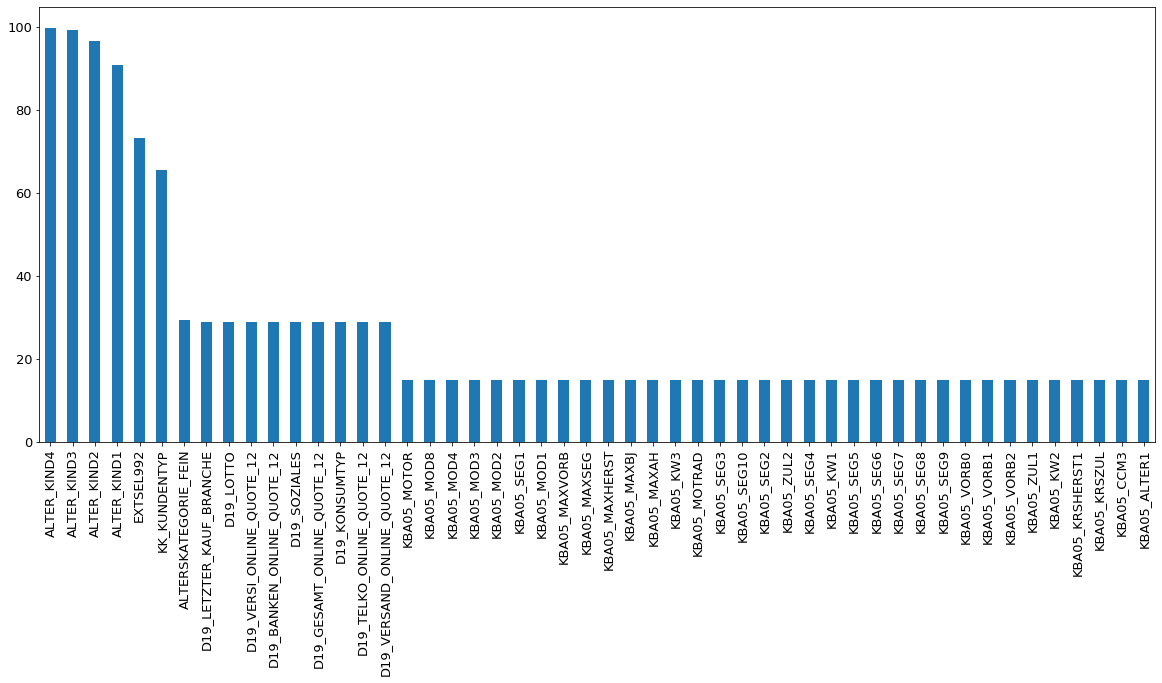

In [27]:
%%time

VisualizeNan(azdiasCopy)

VisualizeNan
CPU times: user 303 ms, sys: 57 µs, total: 303 ms
Wall time: 301 ms


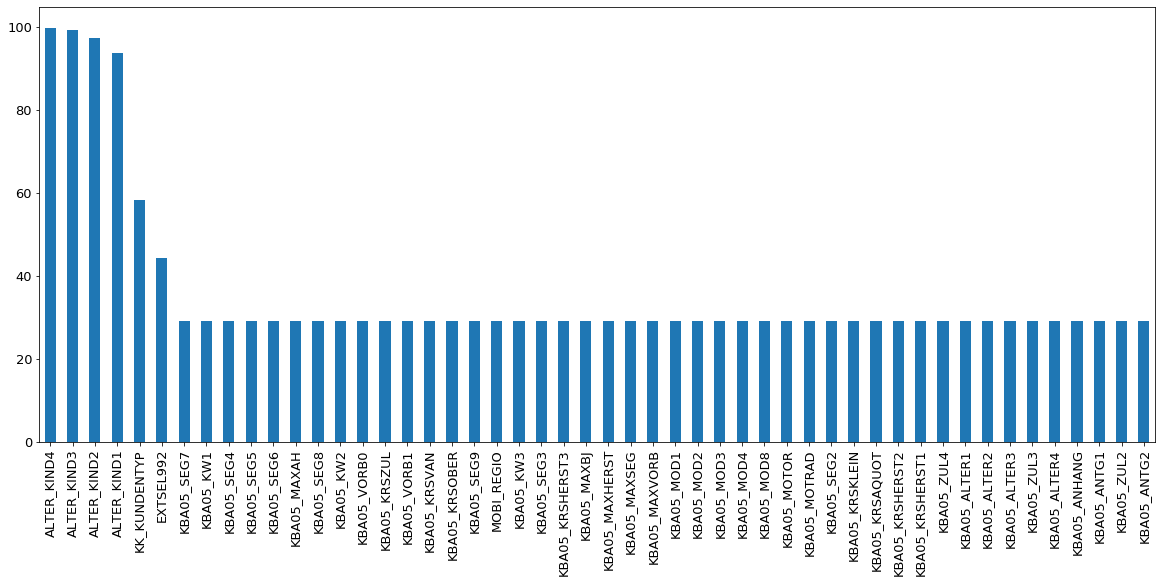

In [28]:
%%time

VisualizeNan(customersCopy)

In [29]:
## 2. Get distribution of missing values for all columns

def DropColumnsWithHigherNanPercentageThan(df, threshhold):
    '''
    Clean the dataframe by dropping columns that have a higher percentage of NaN than a given threshhold 
    
    INPUT: 
        df: Dataframe to clean
        threshhold: % that NaN % needs to exceed to fulfill dropping criteria
        
    OUTPUT:
        Cleaned dataframe
    '''
    print('DropColumnsWithHigherNanPercentageThan')
    nanDistribution = df.isna().mean().round(4) * 100
    
    nanDistribution = nanDistribution.sort_values(ascending=False)
    #nanDistribution.plot.bar()
    #rcParams['figure.figsize'] = 500, 50
    #plt.show()
    #display(nanDistribution)

    ## total 38 columns with threshhold% or above nans, lets drop those columns
    dropList = []
    for (columnName, columnValue) in nanDistribution.items():
        if columnValue > threshhold:
            print('Column dropped: ', columnName)
            dropList.append(columnName)
            
    try:
        df = df.drop(columns = dropList)
    except:
        print('failed to drop columns')

    return df

In [30]:
%%time

threshhold = 33.33
customersCopy = DropColumnsWithHigherNanPercentageThan(customersCopy, threshhold)
print(customersCopy.shape)

DropColumnsWithHigherNanPercentageThan
(191652, 358)
CPU times: user 286 ms, sys: 84.1 ms, total: 370 ms
Wall time: 368 ms


In [31]:
%%time

threshhold = 33.33
azdiasCopy = DropColumnsWithHigherNanPercentageThan(azdiasCopy, threshhold)
print(azdiasCopy.shape)

DropColumnsWithHigherNanPercentageThan
(891221, 355)
CPU times: user 1.19 s, sys: 628 ms, total: 1.82 s
Wall time: 1.82 s


In [32]:
## 3. Unique value columns

def PrintUniqueValuesForColumns(df):
    '''
    Print the unique values for each column of the given dataframe 
    
    INPUT: 
        df: Dataframe to analyze
    '''
    print('PrintUniqueValuesForColumns')
    i = 0;
    uniqueValuesDistribution = {}
    for column_name in df.columns.values:
        print(column_name)
        uniqueLength = len(df[column_name].unique())
        uniqueValuesDistribution[column_name] = uniqueLength

        print(i, 'ColumnName: ', column_name, 'UniqueLength', uniqueLength)
        print('Unique Values: ', df[column_name].unique())

        i += 1

In [33]:
%%time

PrintUniqueValuesForColumns(customersCopy)

PrintUniqueValuesForColumns
LNR
0 ColumnName:  LNR UniqueLength 191652
Unique Values:  [  9626   9628 143872 ... 148813 148852 148883]
AKT_DAT_KL
1 ColumnName:  AKT_DAT_KL UniqueLength 10
Unique Values:  [ 1.  9.  3.  7.  5.  2. nan  4.  6.  8.]
ALTERSKATEGORIE_FEIN
2 ColumnName:  ALTERSKATEGORIE_FEIN UniqueLength 26
Unique Values:  [10. nan  0.  8. 14.  9.  4. 13.  6. 12. 19. 17. 15. 11. 16.  7. 18. 21.
 25. 20. 24.  5.  2. 22.  3. 23.]
ANZ_HAUSHALTE_AKTIV
3 ColumnName:  ANZ_HAUSHALTE_AKTIV UniqueLength 217
Unique Values:  [  1.  nan   0.   7.  74.   9.  17.  12.  29.   2.  45.  10.  14.  15.
  55.   6.   5. 108.   3.  25.  18.   4.  11.  19.   8.  26.  43.  63.
  47.  16.  31.  57.  37.  13.  22.  20.  23.  27. 305.  52.  21.  34.
  46.  24.  33.  51. 523. 104. 101.  59.  44.  38.  61.  69.  28.  48.
  40.  39. 145. 107.  32.  76. 117.  87.  84.  41. 286.  92. 222. 119.
  71.  36. 344.  42.  82. 160.  35.  67.  30. 112.  85.  93.  58.  60.
 221.  77. 102. 140.  79.  53. 290. 243. 105

In [34]:
%%time

PrintUniqueValuesForColumns(azdiasCopy)

PrintUniqueValuesForColumns
LNR
0 ColumnName:  LNR UniqueLength 891221
Unique Values:  [910215 910220 910225 ... 825772 825776 825787]
AKT_DAT_KL
1 ColumnName:  AKT_DAT_KL UniqueLength 10
Unique Values:  [nan  9.  1.  5.  8.  7.  6.  4.  3.  2.]
ALTERSKATEGORIE_FEIN
2 ColumnName:  ALTERSKATEGORIE_FEIN UniqueLength 27
Unique Values:  [nan 21. 17. 13. 14. 10. 16. 20. 11. 19. 15. 18.  9. 22. 12.  0.  8.  7.
 23.  4. 24.  6.  3.  2.  5. 25.  1.]
ANZ_HAUSHALTE_AKTIV
3 ColumnName:  ANZ_HAUSHALTE_AKTIV UniqueLength 293
Unique Values:  [ nan  11.  10.   1.   3.   5.   4.   6.   2.   9.   0.  14.  13.   8.
   7.  44.  25.  36.  16. 272.  33.  15.  12.  22.  21.  20.  67.  23.
  18.  27.  24.  31.  39.  19.  30.  17.  29.  61.  54.  88.  49.  60.
  38.  34.  48.  35.  62.  26.  45.  42.  28.  77.  47.  50. 236. 137.
  43.  52.  41.  76.  63.  32.  40.  37.  59.  53.  57. 118.  66.  95.
  78.  70.  46. 185.  73. 154.  80. 102.  92. 126.  94.  71.  68.  81.
  69. 121. 258.  58.  86. 124.  85.  90.

In [35]:
## drop columns  due to reasons above
def DropMiscColumns(df, dropColumns):
    '''
    Drop a list of columns for a given dataframe
    
    INPUT: 
        df: Dataframe to process
        dropColumns: List of columns to drop
        
    OUTPUT:
        The processed dataframe
    '''
    print('DropMiscColumns')
    print(dropColumns)
    df = df.drop(columns=dropColumns)
    print(df.shape)
    return df

In [36]:
dropColumnList = [
    'AKT_DAT_KL', # we dont know what the values represents
    'ALTERSKATEGORIE_FEIN', # FEIN vs GROB
    'ANREDE_KZ', # only male and unknown gender, Gender
    ##'ANZ_KINDER', # we dont know what the values represents, Children
    'ANZ_STATISTISCHE_HAUSHALTE', # we dont know what the values represents, Statistical Budget
    'ARBEIT', # we dont know what the values represents, Job
    'CAMEO_DEU_2015', # too many values
    'CJT_KATALOGNUTZER', # we dont know what the values represents, Catalog Users
    'CJT_TYP_1', # we dont know what the values represents
    'CJT_TYP_2', # we dont know what the values represents
    'CJT_TYP_3', # we dont know what the values represents
    'CJT_TYP_4', # we dont know what the values represents 
    'CJT_TYP_5', # we dont know what the values represents
    'CJT_TYP_6', # we dont know what the values represents
    ##'D19_BUCH_CD', # we dont know what the values represents, transactional activity based on the product group BOOKS and CDS
    'D19_KONSUMTYP_MAX', # we dont know what the values represents, Consumption Type
    'D19_LETZTER_KAUF_BRANCHE', # too many values, Last Purchase Industry
    'D19_SOZIALES', # we dont know what the values represents, Social
    'D19_TELKO_ONLINE_QUOTE_12', # we dont know what the values represents
    'D19_VERSI_DATUM', # we dont know what the values represents
    'D19_VERSI_OFFLINE_DATUM', # we dont know what the values represents
    'D19_VERSI_ONLINE_DATUM', # we dont know what the values represents
    'D19_VERSI_ONLINE_QUOTE_12', # we dont know what the values represents
    'DSL_FLAG', # we dont know what the values represents
    'EINGEFUEGT_AM', # we dont know what the values represents, Inserted at
    'EINGEZOGENAM_HH_JAHR', # we dont know what the values represents
    'FIRMENDICHTE', # we dont know what the values represents, Company Density
    'GEMEINDETYP', # we dont know what the values represents
    'HH_DELTA_FLAG', # we dont know what the values represents
    'KBA13_ANTG1', # we dont know what the values represents
    'KBA13_ANTG2', # we dont know what the values represents
    'KBA13_ANTG3', # we dont know what the values represents
    'KBA13_ANTG4', # we dont know what the values represents
    'KBA13_BAUMAX', # we dont know what the values represents
    'KBA13_GBZ', # we dont know what the values represents
    'KBA13_HHZ', # we dont know what the values represents
    'KBA13_KMH_210', # we dont know what the values represents
    'KOMBIALTER', # we dont know what the values represents, More Combined
    'KONSUMZELLE', # we dont know what the values represents, Consumer Cell
    'LNR', # all unique values
    'LP_FAMILIE_FEIN', # FEIN vs GROB
    'LP_LEBENSPHASE_FEIN', # FEIN vs GROB
    'LP_STATUS_FEIN', # FEIN vs GROB
    'MIN_GEBAEUDEJAHR', # does not seem to be important
    'MOBI_RASTER', # we dont know what the values represents, mobile grid
    'RT_KEIN_ANREIZ', # we dont know what the values represents, No Incentive
    'RT_SCHNAEPPCHEN', # we dont know what the values represents, Discount
    'RT_UEBERGROESSE', # we dont know what the values represents, OverSize
    'SOHO_KZ', # we dont know what the values represents
    'STRUKTURTYP', # we dont know what the values represents, Structure Type
    'UMFELD_ALT', # we dont know what the values represents, Environment Old
    'UMFELD_JUNG', # we dont know what the values represents, Enironment Young
    'UNGLEICHENN_FLAG', # we dont know what the values represents, Different Flag/ Unique ID
    'VERDICHTUNGSRAUM', # we dont know what the values represents, Compression Space
    'VHA', # we dont know what the values represents
    'VHN', # we dont know what the values represents
    'VK_DHT4A', # we dont know what the values represents
    'VK_DISTANZ', # we dont know what the values represents, Distance
    'VK_ZG11', # we dont know what the values represents
]

In [37]:
%%time

customersCopy = DropMiscColumns(customersCopy, dropColumnList)
print(customersCopy.shape)

DropMiscColumns
['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ANREDE_KZ', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'CAMEO_DEU_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_KONSUMTYP_MAX', 'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210', 'KOMBIALTER', 'KONSUMZELLE', 'LNR', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN', 'MIN_GEBAEUDEJAHR', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SOHO_KZ', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11']
(191652, 301)
(191652, 301)

In [38]:
%%time

azdiasCopy = DropMiscColumns(azdiasCopy, dropColumnList)
print(azdiasCopy.shape)

DropMiscColumns
['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ANREDE_KZ', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'CAMEO_DEU_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_KONSUMTYP_MAX', 'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210', 'KOMBIALTER', 'KONSUMZELLE', 'LNR', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN', 'MIN_GEBAEUDEJAHR', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SOHO_KZ', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11']
(891221, 298)
(891221, 298)

In [39]:
%%time

dropExtraColumnsList = [
    'CUSTOMER_GROUP', # does not exist in azdias
    'ONLINE_PURCHASE', # we dont know what the values represents, also doesnt exist in azdias
    'PRODUCT_GROUP', # does not exist in azdias 
]
customersCopy = DropMiscColumns(customersCopy, dropExtraColumnsList)
print(customersCopy.shape)

DropMiscColumns
['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
(191652, 298)
(191652, 298)
CPU times: user 102 ms, sys: 22 µs, total: 102 ms
Wall time: 101 ms


In [40]:
## 8. Decide about nan rows (drop/give average values etc)
## 8.1 See whats the distribution of NaNs in each row and if we need to drop any

def GetRowNanDistribution(df, threshhold):
    '''
    Print the number and % for rows that have NaNs above a given threshhold % for the given dataframe 
    
    INPUT: 
        df: df to process
        threshhold: The % for NaNs in a row before it can be counted
    '''
    print('GetRowNanDistribution')
    (rows, columns) = df.shape
    print(df.shape)
    temp = 100/columns
    nanPercentageList = (df.isnull().sum(axis=1)*temp).tolist()

    sortedNanPercentageList = nanPercentageList.copy()
    sortedNanPercentageList.sort(reverse=True)
    total = 0
    for datum in sortedNanPercentageList:
        if (datum >= threshhold):
            total += 1
        else:
            break

    print('Total: ', total)
    print('Total % at or above ', str(threshhold),'%: ', (total/rows) * 100)

In [41]:
%%time

threshhold = 30.0
GetRowNanDistribution(customersCopy, threshhold)

GetRowNanDistribution
(191652, 298)
Total:  51281
Total % at or above  30.0 %:  26.75735186692547
CPU times: user 165 ms, sys: 28 µs, total: 165 ms
Wall time: 163 ms


In [42]:
%%time

threshhold = 30.0
GetRowNanDistribution(azdiasCopy, threshhold)

GetRowNanDistribution
(891221, 298)
Total:  105801
Total % at or above  30.0 %:  11.871466224426937
CPU times: user 739 ms, sys: 200 ms, total: 939 ms
Wall time: 935 ms


In [43]:
## add nan percentage column to aid in dropping higher nan rows

def DropNanRowsAboveThreshhold(df, threshhold):
    '''
    Drop rows from the dataframe that have a NaN % higher than the given threshhold
    
    INPUT: 
        df: Dataframe to process
        threshhold: % that needs to be exceeded before a row is dropped
        
    OUTPUT:
        The processed dataframe
    '''
    print('DropNanColumnAboveThreshhold')
    (rows, columns) = df.shape
    temp = 100/columns
    nanPercentageList = (df.isnull().sum(axis=1)*temp).tolist()

    nanPercentageColumnName = 'nanPercentageColumn'
    nanPercentageColumnFrame = pd.DataFrame({nanPercentageColumnName : nanPercentageList})
    df = pd.concat([df, nanPercentageColumnFrame], axis = 1)

    df = df.loc[df[nanPercentageColumnName] < threshhold]
    df = df.drop(columns=[nanPercentageColumnName])
    df.reset_index(drop=True, inplace=True)
    
    return df

In [44]:
%%time

threshhold = 30.0
customersCopy = DropNanRowsAboveThreshhold(customersCopy, threshhold)
print(customersCopy.shape)

DropNanColumnAboveThreshhold
(140371, 298)
CPU times: user 529 ms, sys: 364 ms, total: 893 ms
Wall time: 892 ms


In [45]:
%%time

threshhold = 30.0
azdiasCopy = DropNanRowsAboveThreshhold(azdiasCopy, threshhold)
print(azdiasCopy.shape)

DropNanColumnAboveThreshhold
(785420, 298)
CPU times: user 2.49 s, sys: 2.14 s, total: 4.64 s
Wall time: 4.63 s


In [46]:
## binary encoding

def BinaryEncode_OST_WEST_KZ_VERS_TYP(df):
    '''
    Process the dataframe to binary encode the columns 'OST_WEST_KZ' and 'VERS_TYPE' 
    
    INPUT: 
        df: Dataframe to process
        
    OUTPUT:
        Return the processed dataframe
    '''
    print('BinaryEncode_OST_WEST_KZ_VERS_TYP')
    columnName = 'OST_WEST_KZ'
    df.loc[df[columnName] == 'O', columnName] = 0
    df.loc[df[columnName] == 'W', columnName] = 1

    df.loc[df['VERS_TYP'] == 2, 'VERS_TYP'] = 0
    
    return df

In [47]:
%%time

customersCopy = BinaryEncode_OST_WEST_KZ_VERS_TYP(customersCopy)

BinaryEncode_OST_WEST_KZ_VERS_TYP
CPU times: user 5.09 s, sys: 52 ms, total: 5.15 s
Wall time: 5.14 s


In [48]:
%%time

azdiasCopy = BinaryEncode_OST_WEST_KZ_VERS_TYP(azdiasCopy)

BinaryEncode_OST_WEST_KZ_VERS_TYP
CPU times: user 28.4 s, sys: 288 ms, total: 28.7 s
Wall time: 28.7 s


In [49]:
## 8.2 Replace NaNs with most frequently used (binary) or mean (int)
## this needs to go after binary encoding of OST_WEST_KZ and PRODUCT_GROUP

def ReplaceNans(df, binaryColumns):
    '''
    Process the dataframe to replace NaN values with medians or most frequently used value 
    
    INPUT: 
        df: Dataframe to process
        binaryColumns: List of columns with binary values
        
    OUTPUT:
        The process dataframe
    '''
    print('ReplaceNans')
    i = 0
    for columnName in df.columns:
        print(i, 'ColumnName: ', columnName)
        i += 1
        if columnName in binaryColumns:
            # binary data
            # replace NaN with most frequently used value
            mostFrequentlyUsed = df[columnName].value_counts().idxmax()
            print('most frequently used: ', mostFrequentlyUsed)
            df.loc[df[columnName].isnull(), columnName] = mostFrequentlyUsed
        else:
            # numerical data
            # replace NaN with median
            median = df[columnName].median(axis = 0, skipna = True) 
            print('median value: ', median)
            df.loc[df[columnName].isnull(), columnName] = median
            
    return df

In [50]:
%%time

binaryValueColumns = [
    'GREEN_AVANTGARDE',
    'VERS_TYP',
    'OST_WEST_KZ'
]

customersCopy = ReplaceNans(customersCopy, binaryValueColumns)  

print(customersCopy.shape)

ReplaceNans
0 ColumnName:  ANZ_HAUSHALTE_AKTIV
median value:  1.0
1 ColumnName:  ANZ_HH_TITEL
median value:  0.0
2 ColumnName:  ANZ_KINDER
median value:  0.0
3 ColumnName:  ANZ_PERSONEN
median value:  2.0
4 ColumnName:  ANZ_TITEL
median value:  0.0
5 ColumnName:  BALLRAUM
median value:  5.0
6 ColumnName:  CAMEO_DEUG_2015
median value:  4.0
7 ColumnName:  CAMEO_INTL_2015
median value:  24.0
8 ColumnName:  CJT_GESAMTTYP
median value:  3.0
9 ColumnName:  D19_BANKEN_ANZ_12
median value:  0.0
10 ColumnName:  D19_BANKEN_ANZ_24
median value:  0.0
11 ColumnName:  D19_BANKEN_DATUM
median value:  10.0
12 ColumnName:  D19_BANKEN_DIREKT
median value:  0.0
13 ColumnName:  D19_BANKEN_GROSS
median value:  0.0
14 ColumnName:  D19_BANKEN_LOKAL
median value:  0.0
15 ColumnName:  D19_BANKEN_OFFLINE_DATUM
median value:  10.0
16 ColumnName:  D19_BANKEN_ONLINE_DATUM
median value:  10.0
17 ColumnName:  D19_BANKEN_ONLINE_QUOTE_12
median value:  0.0
18 ColumnName:  D19_BANKEN_REST
median value:  0.0
19 ColumnN

In [51]:
%%time

binaryValueColumns = [
    'GREEN_AVANTGARDE',
    'VERS_TYP',
    'OST_WEST_KZ'
]

azdiasCopy = ReplaceNans(azdiasCopy, binaryValueColumns)

print(azdiasCopy.shape)

ReplaceNans
0 ColumnName:  ANZ_HAUSHALTE_AKTIV
median value:  4.0
1 ColumnName:  ANZ_HH_TITEL
median value:  0.0
2 ColumnName:  ANZ_KINDER
median value:  0.0
3 ColumnName:  ANZ_PERSONEN
median value:  1.0
4 ColumnName:  ANZ_TITEL
median value:  0.0
5 ColumnName:  BALLRAUM
median value:  5.0
6 ColumnName:  CAMEO_DEUG_2015
median value:  6.0
7 ColumnName:  CAMEO_INTL_2015
median value:  41.0
8 ColumnName:  CJT_GESAMTTYP
median value:  4.0
9 ColumnName:  D19_BANKEN_ANZ_12
median value:  0.0
10 ColumnName:  D19_BANKEN_ANZ_24
median value:  0.0
11 ColumnName:  D19_BANKEN_DATUM
median value:  10.0
12 ColumnName:  D19_BANKEN_DIREKT
median value:  0.0
13 ColumnName:  D19_BANKEN_GROSS
median value:  0.0
14 ColumnName:  D19_BANKEN_LOKAL
median value:  0.0
15 ColumnName:  D19_BANKEN_OFFLINE_DATUM
median value:  10.0
16 ColumnName:  D19_BANKEN_ONLINE_DATUM
median value:  10.0
17 ColumnName:  D19_BANKEN_ONLINE_QUOTE_12
median value:  0.0
18 ColumnName:  D19_BANKEN_REST
median value:  0.0
19 ColumnN

In [52]:
## splitting some columns
## can **NOT** run this more than once

## input is 21 (int)
## output needs to be 2 and 1 (respectively)
## strategy is to convert to string and get the first character and convert back to int
def GetFirst(intValue):
    '''
    Return the first digit of a two digit integer. Helper function for Split4Columns()
    
    INPUT: 
        intValue: Two digit integer
        
    OUTPUT:
        First digit of the two digit integer
    '''
    intValue = int(round(intValue))
    retVal =  int(str(intValue)[0])
    return retVal
def GetSecond(intValue):
    '''
    Return the second digit of a two digit integer. Helper function for Split4Columns()
    
    INPUT: 
        intValue: Two digit integer
        
    OUTPUT:
        Second digit of the two digit integer
    '''
    intValue = int(round(intValue))
    retVal = int(str(intValue)[1])
    return retVal

def GetFamily(intValue):
    '''
    Returns if the given value represents Family or not. Helper function for Split4Columns()
    
    INPUT: 
        intValue: Integer representing Family or Business
        
    OUTPUT:
        Binary value depending on whether input represents Family
    '''
    intValue = int(round(intValue))
    if intValue <= 4:
        return 1.0
    elif intValue >= 5:
        return 0.0
    else:
        print('Error in GetFamily: ', intValue)
def GetBusiness(intValue):
    '''
    Returns if the given value represents Business or not. Helper function for Split4Columns()
    
    INPUT: 
        intValue: Integer representing Family or Business
        
    OUTPUT:
        Binary value depending on whether input represents Family
    '''
    intValue = int(round(intValue))
    if intValue <= 4:
        return 0.0
    elif intValue >= 5:
        return 1.0
    else:
        print('Error in GetBusiness: ', intValue)
        
def GetRural(intValue):
    '''
    Returns if the given value represents Rural or not. Helper function for Split4Columns()
    
    INPUT: 
        intValue: Integer representing Rural or not
        
    OUTPUT:
        Binary value depending on whether input represents Rural
    '''
    intValue = int(round(intValue))
    if intValue <=5:
        return 0.0
    elif intValue >= 7:
        return 1.0
    else:
        print('Error in GetRural: ', intValue)

def GetGeneration(intValue):
    '''
    Return the Generation (40's, 50's,..90's) based on the input where multiple input maps to the same Generation.
    Helper function for Split4Columns()
    
    INPUT: 
        intValue: Integer representing Generation
        
    OUTPUT:
        Integer representing Generation
    '''
    intValue = int(round(intValue))
    if intValue <= 2:
        return 1.0
    elif intValue <= 4:
        return 2.0
    elif intValue <= 7:
        return 3.0
    elif intValue <= 9:
        return 4.0
    elif intValue <= 13:
        return 5.0
    elif intValue <= 15:
        return 6.0
    else:
        print('Error in GetGeneration: ', intValue)
def GetMovement(intValue):
    '''
    Return the Movement (Mainstream, Avantagrde) based on the input where multiple input maps to the same Movement.
    Helper function for Split4Columns()
    
    INPUT: 
        intValue: Integer representing Movement
        
    OUTPUT:
        Integer representing Movement
    '''
    ms = [1,3,5,8,10,12,14]
    ag = [2,4,6,7,9,11,13,15]

    intValue = int(round(intValue))
    if intValue in ms:
        return 0.0
    elif intValue in ag:
        return 1.0
    else:
        print('Error in GetMovement: ', intValue)


def Split4Columns(df):
    '''
    Process the dataframe to split 4 specific columns: 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'PLZ8_BAUMAX', 'WOHNLAGE'
    
    INPUT: 
        df: Dataframe to process
        
    OUTPUT:
        Processed dataframe
    '''
    print('Split4Columns')
    (row, column) = df.shape
    
    ## 1. CAMEO_INTL_2015
    columnName = 'CAMEO_INTL_2015'

    newColumnName = 'CI2_WealthType'
    if newColumnName not in df.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        df = pd.concat([df, dummyColumn], axis = 1)
        df[newColumnName] = df.apply(lambda row: GetFirst(row[columnName]), axis=1)

    newColumnName = 'CI2_FamilyType'
    if newColumnName not in df.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        df = pd.concat([df, dummyColumn], axis = 1)
        df[newColumnName] = df.apply(lambda row: GetSecond(row[columnName]), axis=1)

    df = df.drop(columns=[columnName])

    
    ## 2. PRAEGENDE_JUGENDJAHRE
    columnName = 'PRAEGENDE_JUGENDJAHRE'

    newColumnName = 'PJ_Movement'
    if newColumnName not in df.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        df = pd.concat([df, dummyColumn], axis = 1)
        df[newColumnName] = df.apply(lambda row: GetMovement(row[columnName]), axis=1)

    newColumnName = 'PJ_Generation'
    if newColumnName not in df.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        df = pd.concat([df, dummyColumn], axis = 1)
        df[newColumnName] = df.apply(lambda row: GetGeneration(row[columnName]), axis=1)

    df = df.drop(columns=[columnName])
    

    ## 3. PLZ8_BAUMAX
    columnName = 'PLZ8_BAUMAX'

    newColumnName = 'PB_Family'
    if newColumnName not in df.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        df = pd.concat([df, dummyColumn], axis = 1)
        df[newColumnName] = df.apply(lambda row: GetFamily(row[columnName]), axis=1)

    newColumnName = 'PB_Business'
    if newColumnName not in df.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        df = pd.concat([df, dummyColumn], axis = 1)
        df[newColumnName] = df.apply(lambda row: GetBusiness(row[columnName]), axis=1)

    # not dropping since we still have some value for mainly x-y family homes
    #df = df.drop(columns=[columnName])
    

    ## 4. WOHNLAGE
    columnName = 'WOHNLAGE'

    newColumnName = 'WL_Rural'
    if newColumnName not in df.columns:
        dummyColumnValues = [0] * row
        dummyColumn = pd.DataFrame({newColumnName: dummyColumnValues})
        df = pd.concat([df, dummyColumn], axis = 1)
        df[newColumnName] = df.apply(lambda row: GetRural(row[columnName]), axis=1)

    # not dropping since we still have some value for neighbourhood type
    #df = df.drop(columns=[columnName])

    return df

In [53]:
%%time

customersCopy = Split4Columns(customersCopy) 

Split4Columns
CPU times: user 34.7 s, sys: 7.25 s, total: 41.9 s
Wall time: 41.9 s


In [54]:
%%time

azdiasCopy = Split4Columns(azdiasCopy)  

Split4Columns
CPU times: user 3min 27s, sys: 51.8 s, total: 4min 19s
Wall time: 4min 19s


In [55]:
## convert to int

def ConvertToInt(df):
    '''
    Process the dataframe convert all values to integer
    
    INPUT: 
        df: Dataframe to process
        
    OUTPUT:
        Processed dataframe
    '''
    print('ConvertToInt')
    return df.astype(int)

In [56]:
%%time

azdiasCopy = ConvertToInt(azdiasCopy)

ConvertToInt
CPU times: user 1.25 s, sys: 1.15 s, total: 2.4 s
Wall time: 2.4 s


In [57]:
%%time

customersCopy = ConvertToInt(customersCopy)

ConvertToInt
CPU times: user 215 ms, sys: 72 ms, total: 287 ms
Wall time: 284 ms


In [58]:
%%time
## Write to the pickle file

writeAzdiasCustomersToPickle()

WriteToPickle:  azdias
WriteToPickle:  customers
CPU times: user 1.35 s, sys: 3.36 s, total: 4.7 s
Wall time: 4.75 s


In [59]:
## Removing outliers
## Ref: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

def RemoveOutliers(df, columnsToExclude, threshhold):
    '''
    Process the dataframe to drop rows that have any outliers in their columns
    
    INPUT: 
        df: Dataframe to process
        columnstoExceed: Columns to avoid searching for outliers
        threshhold: Delta that needs to exceed for a difference between [row][column] value and
                    Standard Deviation of column values before a row is dropped
        
    OUTPUT:
        Processed dataframe
    '''
    print('RemoveOutliers')
    columnNames = [item for item in list(df.columns.values) if item not in columnsToExclude]
    print(df.shape)

    # keep ones within +6 to -6 sd in each column
    for column in columnNames:
        df = df[np.abs(df[column] - df[column].mean()) <= (threshhold * df[column].std())]
    
    print(df.shape)
    return df

In [60]:
%%time

excludedColumns = [
    'OST_WEST_KZ', # categorical/binary
    'GREEN_AVANTGARDE', # binary
    'VERS_TYP', # binary
    'WL_Rural', # binary
    'PB_Family', # binary
    'PB_Business', # binary
    'PJ_Movement', # binary
]
threshhold = 6
customersCopy = RemoveOutliers(customersCopy, excludedColumns, threshhold)

RemoveOutliers
(140371, 303)
(126385, 303)
CPU times: user 20.5 s, sys: 10.5 s, total: 30.9 s
Wall time: 30.9 s


In [61]:
%%time

azdiasCopy = RemoveOutliers(azdiasCopy, excludedColumns, threshhold)

RemoveOutliers
(785420, 303)
(715555, 303)
CPU times: user 1min 41s, sys: 1min 56s, total: 3min 37s
Wall time: 3min 37s


In [62]:
%%time

preScalingAzdias = azdiasCopy.copy()

CPU times: user 279 ms, sys: 412 ms, total: 691 ms
Wall time: 690 ms


In [63]:
%%time

preScalingCustomers = customersCopy.copy()

CPU times: user 35.9 ms, sys: 3.75 ms, total: 39.7 ms
Wall time: 38.6 ms


In [64]:
## Feature Scaling

def ScaleFeature(df):
    '''
    Process the dataframe by standardizing features by removing the mean and scaling to unit variance
    
    INPUT: 
        df: Dataframe to process
        
    OUTPUT:
        Processed dataframe and scaler
    '''
    print('ScaleFeature')
    scaler = StandardScaler()
    scaledDf = pd.DataFrame(scaler.fit_transform(df))

    return (scaledDf, scaler)

def ScaleFeatureWithScaler(df, scaler):
    '''
    Process the dataframe by standardizing features by removing the mean and scaling to unit variance
    
    INPUT: 
        df: Dataframe to process
        scaler: Scaler to transform with 
        
    OUTPUT:
        Processed dataframe
    '''
    print('ScaleFeatureWithScaler')
    return pd.DataFrame(scaler.transform(df))

In [65]:
%%time

(scaledAzdias, scaler) = ScaleFeature(azdiasCopy)

ScaleFeature
CPU times: user 3.96 s, sys: 1.51 s, total: 5.47 s
Wall time: 5.47 s


In [66]:
%%time

scaledCustomers = ScaleFeatureWithScaler(customersCopy, scaler)

ScaleFeatureWithScaler
CPU times: user 170 ms, sys: 68.1 ms, total: 238 ms
Wall time: 236 ms


In [67]:
%%time
## save processed data to *.csv files

customersCopy.to_csv('customersCopy.csv', index = False)
scaledCustomers.to_csv('scaledCustomers.csv', index = False)

azdiasCopy.to_csv('azdiasCopy.csv', index = False)
scaledAzdias.to_csv('scaledAzdias.csv', index = False)

CPU times: user 7min 19s, sys: 4.42 s, total: 7min 24s
Wall time: 7min 24s


In [5]:
%%time
## read processed data from *.csv files

customersCopy = pd.read_csv('customersCopy.csv')
scaledCustomers = pd.read_csv('scaledCustomers.csv')

azdiasCopy = pd.read_csv('azdiasCopy.csv')
scaledAzdias = pd.read_csv('scaledAzdias.csv')

CPU times: user 1min 11s, sys: 3.48 s, total: 1min 14s
Wall time: 13min 54s


In [85]:
## Lets do PCA!

def DoPCA(df, components):
    '''
    Run Principal Component Analysis
    
    INPUT: 
        df: Dataframe to run PCA on
        components: Number of components wanted
        
    OUTPUT:
        PCA object and principal components
    '''
    print('DoPCA: ', components)
    pca = PCA(n_components = components)

    print('PCA Parameters: ', pca)

    principalComponents = pca.fit_transform(df)
    
    return (pca, principalComponents)

In [86]:
%%time

(pcaScaledAzdiasAll, pcScaledAzdiasAll) = DoPCA(scaledAzdias, None)

DoPCA:  None
PCA Parameters:  PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
CPU times: user 38.4 s, sys: 2.03 s, total: 40.4 s
Wall time: 8.59 s


In [87]:
## draw graph from pca variance per principal component

def GraphPCAVariance(explainedVariance):
    '''
    Plot a graph of Principal Components vs Variance %
    
    INPUT: 
        explainedVariance: Explained Variance Ratio
    '''
    print('GraphPCAVariance')
    cumulativeVariance = list(accumulate(explainedVariance))

    xValues = [1] * len(cumulativeVariance)
    xValues[0] = 0
    xValues = list(accumulate(xValues))
    xColumn = pd.DataFrame({'X' : xValues})
    yColumn = pd.DataFrame({'Y' : cumulativeVariance})

    ## plot
    plt.title('Computed Cumulative Variance for Principal Components')
    plt.xlabel("Principal Components")
    plt.ylabel("Variance %")
    plt.plot(xColumn, yColumn, 'r')

GraphPCAVariance
CPU times: user 18.9 ms, sys: 122 µs, total: 19 ms
Wall time: 17.9 ms


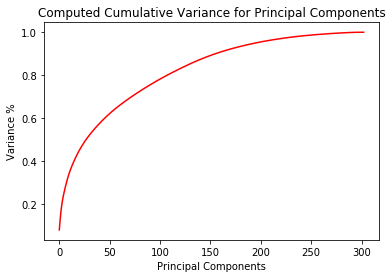

In [88]:
%%time

varianceSeriesAzdiasAll = pcaScaledAzdiasAll.explained_variance_ratio_
GraphPCAVariance(varianceSeriesAzdiasAll)

In [89]:
def GetNumberOfFeaturesForVariancePercentage(pca, threshhold):
    '''
    Compute the number of components needed to achieve the threshhold variance
    
    INPUT: 
        pca: PCA object
        threshhold: Variance % desired
        
    OUTPUT:
        Number of components needed to achieve threshhold variance
    '''
    print('GetNumberOfFeaturesForVariancePercentage')
    varianceSeries = pca.explained_variance_ratio_

    sum = 0
    i = 0
    for number in varianceSeries:
        sum += number
        i += 1
        if sum >= threshhold:
            break

    return i

In [90]:
%%time

threshhold = 0.95
numberOfComponents = GetNumberOfFeaturesForVariancePercentage(pcaScaledAzdiasAll, threshhold)
print('Number Of Components to make variance of ', (threshhold * 100), '%', ' : ', numberOfComponents)

GetNumberOfFeaturesForVariancePercentage
Number Of Components to make variance of  95.0 %  :  196
CPU times: user 1.15 ms, sys: 54 µs, total: 1.21 ms
Wall time: 648 µs


In [91]:
%%time

(pcaScaledAzdiasN, pcScaledAzdiasN) = DoPCA(scaledAzdias, numberOfComponents)

DoPCA:  196
PCA Parameters:  PCA(copy=True, iterated_power='auto', n_components=196, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
CPU times: user 1min 45s, sys: 26 s, total: 2min 11s
Wall time: 32.6 s


GraphPCAVariance
CPU times: user 18.1 ms, sys: 4.11 ms, total: 22.2 ms
Wall time: 18.8 ms


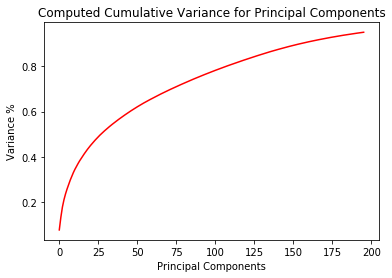

In [92]:
%%time

varianceSeriesAzdiasN = pcaScaledAzdiasN.explained_variance_ratio_
GraphPCAVariance(varianceSeriesAzdiasN)

In [93]:
%%time

pcScaledCustomersN = pcaScaledAzdiasN.transform(scaledCustomers)

CPU times: user 627 ms, sys: 108 ms, total: 735 ms
Wall time: 265 ms


In [94]:
## Display PCA feature component
# Copied over from course materials

def DisplayComponent(v, features_list, component_num, column, n_weights = 10):
    '''
    Display the components of a PCA component in a graph
    
    INPUT: 
        v: Dataframe of PCA components
        features_list: List of columns of the dataframe being analyzed
        component_num: The PCA component number to display the components of
        column: Number of columns in the dataframe being analyzed
        n_weights: weight
    '''
    print('DisplayComponent')
    N_COMPONENTS = column - 1
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v[:, row_idx]
    v_1 = np.squeeze(v_1_row)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

DisplayComponent


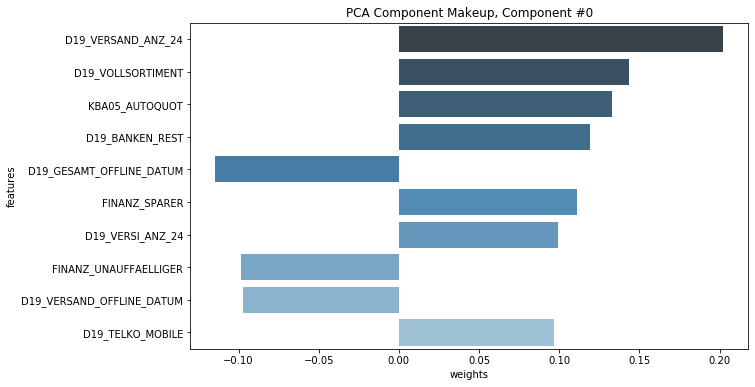

CPU times: user 224 ms, sys: 8.02 ms, total: 232 ms
Wall time: 229 ms


In [95]:
%%time

weight = 10
componentNumber = 0
DisplayComponent(pcaScaledAzdiasN.components_, list(azdiasCopy.columns), component_num = componentNumber, column = scaledAzdias.shape[1], n_weights = weight)

DisplayComponent


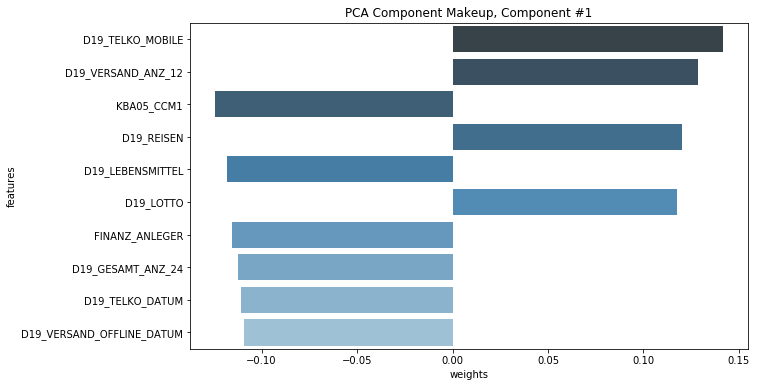

CPU times: user 296 ms, sys: 4.59 ms, total: 301 ms
Wall time: 289 ms


In [96]:
%%time

weight = 10
componentNumber = 1
DisplayComponent(pcaScaledAzdiasN.components_, list(azdiasCopy.columns), component_num = componentNumber, column = scaledAzdias.shape[1], n_weights = weight)

DisplayComponent


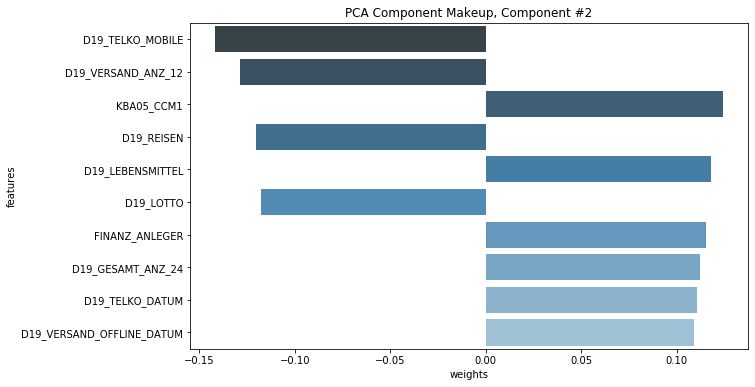

CPU times: user 230 ms, sys: 4.71 ms, total: 235 ms
Wall time: 225 ms


In [97]:
%%time

weight = 10
componentNumber = 2
DisplayComponent(pcaScaledAzdiasN.components_, list(azdiasCopy.columns), component_num = componentNumber, column = scaledAzdias.shape[1], n_weights = weight)

DisplayComponent


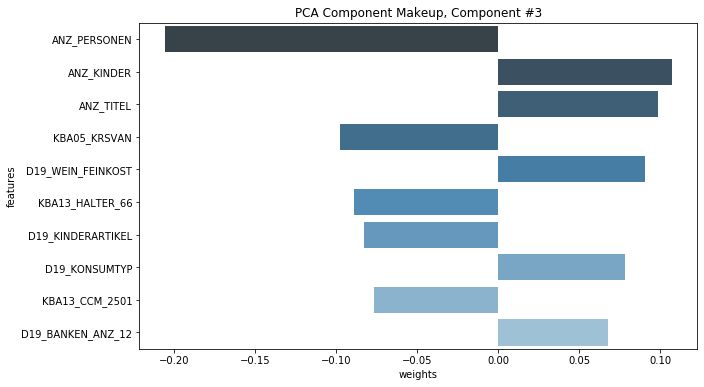

CPU times: user 228 ms, sys: 4.4 ms, total: 233 ms
Wall time: 225 ms


In [98]:
%%time

weight = 10
componentNumber = 3
DisplayComponent(pcaScaledAzdiasN.components_, list(azdiasCopy.columns), component_num = componentNumber, column = scaledAzdias.shape[1], n_weights = weight)

DisplayComponent


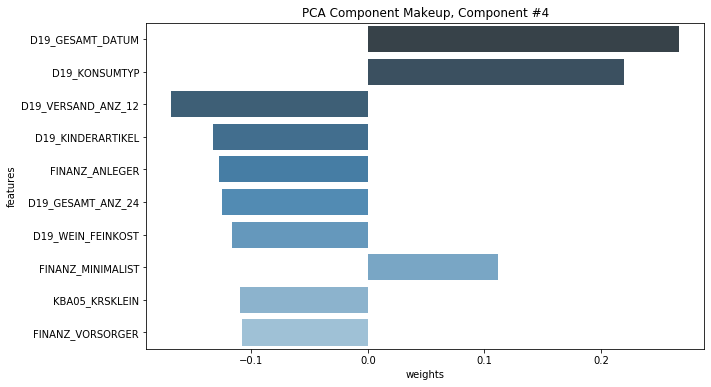

CPU times: user 218 ms, sys: 106 µs, total: 218 ms
Wall time: 214 ms


In [99]:
%%time

weight = 10
componentNumber = 4
DisplayComponent(pcaScaledAzdiasN.components_, list(azdiasCopy.columns), component_num = componentNumber, column = scaledAzdias.shape[1], n_weights = weight)

In [100]:
# Knn

def Knn(data, start, end, step):
    '''
    Run k-means clustering algorithm on the given data
    
    INPUT: 
        data: Dataframe to run k-means clustering algorithm on
        start: starting number of clusters
        end: ending number of clusters
        step: delta change of cluster numbers between each iteration
        
    OUTPUT:
        The score list after each k-means clustering (of different sizes)
    '''
    print('Knn')
    scorelist = []
    for i in range(start, end, step):
        print(i)
        kmeans = KMeans(n_clusters = i)
        model = kmeans.fit(data)
        score = model.score(data)
        scorelist.append(abs(score))

    return scorelist

def DrawElbowPlot(start, end, step, scorelist):
    '''
    Draw the elbow plot given the data
    
    INPUT: 
        start: starting number of clusters
        end: Number of components wanted
        step: delta change of cluster numbers between each iteration/row of data in scorelist
        scorelist: list of scores for k-means clustering for different cluster size
    '''
    print('DrawElbowPlot')
    plt.figure(figsize=(10,14))
    plt.plot(scorelist, color='r', marker='o')
    plt.xlabel('# of clusters K', fontsize=15)
    plt.ylabel('SSE', fontsize=15)
    plt.title('SSE over K', fontsize=15)

In [101]:
%%time

start = 1
end = 20
step = 1

scoreListAzdias = Knn(pcScaledAzdiasN, start, end, step)

Knn
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 1h 58min 3s, sys: 2min 22s, total: 2h 25s
Wall time: 1h 42min 57s


DrawElbowPlot
CPU times: user 19.9 ms, sys: 113 µs, total: 20 ms
Wall time: 17.4 ms


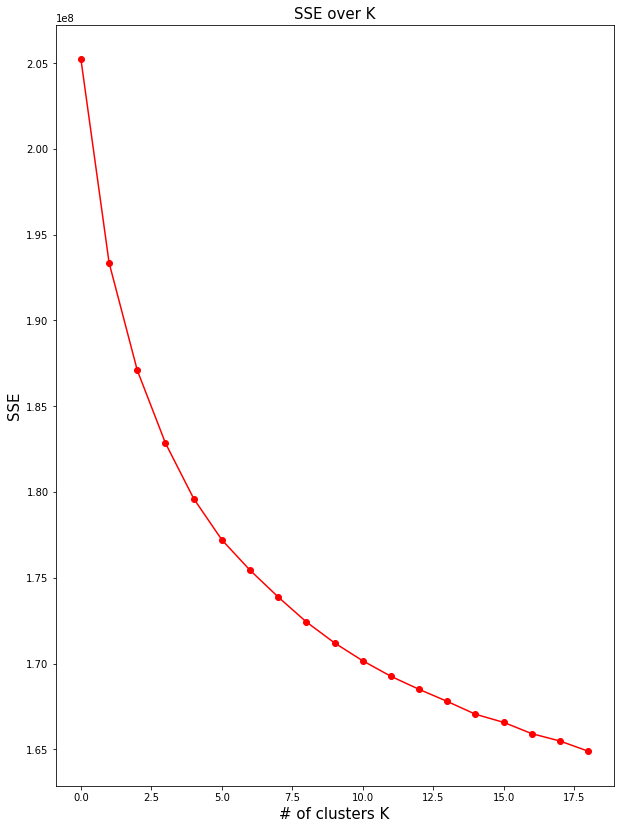

In [102]:
%%time

DrawElbowPlot(start, end, step, scoreListAzdias)

In [103]:
%%time
clusterNumber = 10 # from elbow plot

azdiasKnn = KMeans(n_clusters = clusterNumber)
azdiasKnnModel = azdiasKnn.fit(pcScaledAzdiasN)
azdiasKnnLabels = azdiasKnn.predict(pcScaledAzdiasN)

CPU times: user 6min 6s, sys: 8.19 s, total: 6min 14s
Wall time: 5min 12s


In [104]:
%%time

customersKnnLabels = azdiasKnn.predict(pcScaledCustomersN)

CPU times: user 205 ms, sys: 3.6 ms, total: 209 ms
Wall time: 107 ms


In [ ]:
azdiasData = 0
customersData = 1
dataTypeList = ['Azdias', 'Customers']
def DataCleanUp(df, dataType):
    '''
    Cleanup the given dataframe using specific techniques
    
    INPUT: 
        df: Dataframe to cleanup
        dataType: name of data
        
    OUTPUT:
        The cleaned dataframe
    '''
    print('DataCleanUp: ', dataTypeList[dataType])
    print(df.shape)
    
    # Clean data by marking as NaN
    df = CleanDataBymarkingNaN(df)
    
    # Clean mixed data type columns
    df = CleanupCameo2015(df)
    
    # Drop columns with higher than 33.33% NaNs, calculated before
    threshhold = 33.33
    df = DropColumnsWithHigherNanPercentageThan(df, threshhold)
    print(df.shape)
    
    # Drop misc columns
    dropColumnList = [        
        'AKT_DAT_KL', # we dont know what the values represents
        'ALTERSKATEGORIE_FEIN', # FEIN vs GROB
        'ANREDE_KZ', # only male and unknown gender, Gender
        ##'ANZ_KINDER', # we dont know what the values represents, Children
        'ANZ_STATISTISCHE_HAUSHALTE', # we dont know what the values represents, Statistical Budget
        'ARBEIT', # we dont know what the values represents, Job
        'CAMEO_DEU_2015', # too many values
        'CJT_KATALOGNUTZER', # we dont know what the values represents, Catalog Users
        'CJT_TYP_1', # we dont know what the values represents
        'CJT_TYP_2', # we dont know what the values represents
        'CJT_TYP_3', # we dont know what the values represents
        'CJT_TYP_4', # we dont know what the values represents 
        'CJT_TYP_5', # we dont know what the values represents
        'CJT_TYP_6', # we dont know what the values represents
        ##'D19_BUCH_CD', # we dont know what the values represents, transactional activity based on the product group BOOKS and CDS
        'D19_KONSUMTYP_MAX', # we dont know what the values represents, Consumption Type
        'D19_LETZTER_KAUF_BRANCHE', # too many values, Last Purchase Industry
        'D19_SOZIALES', # we dont know what the values represents, Social
        'D19_TELKO_ONLINE_QUOTE_12', # we dont know what the values represents
        'D19_VERSI_DATUM', # we dont know what the values represents
        'D19_VERSI_OFFLINE_DATUM', # we dont know what the values represents
        'D19_VERSI_ONLINE_DATUM', # we dont know what the values represents
        'D19_VERSI_ONLINE_QUOTE_12', # we dont know what the values represents
        'DSL_FLAG', # we dont know what the values represents
        'EINGEFUEGT_AM', # we dont know what the values represents, Inserted at
        'EINGEZOGENAM_HH_JAHR', # we dont know what the values represents
        'FIRMENDICHTE', # we dont know what the values represents, Company Density
        'GEMEINDETYP', # we dont know what the values represents
        'HH_DELTA_FLAG', # we dont know what the values represents
        'KBA13_ANTG1', # we dont know what the values represents
        'KBA13_ANTG2', # we dont know what the values represents
        'KBA13_ANTG3', # we dont know what the values represents
        'KBA13_ANTG4', # we dont know what the values represents
        'KBA13_BAUMAX', # we dont know what the values represents
        'KBA13_GBZ', # we dont know what the values represents
        'KBA13_HHZ', # we dont know what the values represents
        'KBA13_KMH_210', # we dont know what the values represents
        'KOMBIALTER', # we dont know what the values represents, More Combined
        'KONSUMZELLE', # we dont know what the values represents, Consumer Cell
        'LNR', # all unique values
        'LP_FAMILIE_FEIN', # FEIN vs GROB
        'LP_LEBENSPHASE_FEIN', # FEIN vs GROB
        'LP_STATUS_FEIN', # FEIN vs GROB
        'MIN_GEBAEUDEJAHR', # does not seem to be important
        'MOBI_RASTER', # we dont know what the values represents, mobile grid
        'RT_KEIN_ANREIZ', # we dont know what the values represents, No Incentive
        'RT_SCHNAEPPCHEN', # we dont know what the values represents, Discount
        'RT_UEBERGROESSE', # we dont know what the values represents, OverSize
        'SOHO_KZ', # we dont know what the values represents
        'STRUKTURTYP', # we dont know what the values represents, Structure Type
        'UMFELD_ALT', # we dont know what the values represents, Environment Old
        'UMFELD_JUNG', # we dont know what the values represents, Enironment Young
        'UNGLEICHENN_FLAG', # we dont know what the values represents, Different Flag/ Unique ID
        'VERDICHTUNGSRAUM', # we dont know what the values represents, Compression Space
        'VHA', # we dont know what the values represents
        'VHN', # we dont know what the values represents
        'VK_DHT4A', # we dont know what the values represents
        'VK_DISTANZ', # we dont know what the values represents, Distance
        'VK_ZG11', # we dont know what the values represents
    ]
    df = DropMiscColumns(df, dropColumnList)
    print(df.shape)
    
    if dataType == customerData:
        dropExtraColumnsList = [
            'CUSTOMER_GROUP', # does not exist in azdias
            'ONLINE_PURCHASE', # we dont know what the values represents, also doesnt exist in azdias
            'PRODUCT_GROUP', # does not exist in azdias 
        ]
        df = DropMiscColumns(df, dropExtraColumnsList)
        print(df.shape)
    
    # Drop rows with NaNs more than a certain percentage, calculated before
    threshhold = 30.0
    df = DropNanRowsAboveThreshhold(df, threshhold)
    print(df.shape)
    
    # Binary encode OST_WEST_KZ
    df = BinaryEncode_OST_WEST_KZ_VERS_TYP(df)
    
    # Replace NaN values with median/most frequently used values
    binaryValueColumns = [
        'GREEN_AVANTGARDE',
        'VERS_TYP',
        'OST_WEST_KZ'
    ]
    df = ReplaceNans(df, binaryValueColumns)  
    
    # Split 4 columns
    df = Split4Columns(df)   
        'OST_WEST_KZ', # categorical/binary
        'GREEN_AVANTGARDE', # binary
        'VERS_TYP' # binary
    ]
    threshhold = 6
    df = RemoveOutliers(df, excludedColumns, threshhold)
    
    return df

In [ ]:
%%time

## Pre process
# load in the data
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)

# Clean data
azdias = DataCleanUp(azdias, azdiasData)
customers = DataCleanUp(customers, customersData)

# Scale/Normalize/Standardize data
(scaledAzdias, scaler) = ScaleFeature(azdias)
scaledCustomers = ScaleFeatureWithScaler(customers, scaler)


# PCA
(pcaScaledAzdiasAll, pcScaledAzdiasAll) = DoPCA(scaledAzdias, None)

# Get optimum number of components
threshhold = 0.925
numberOfComponents = GetNumberOfFeaturesForVariancePercentage(pcaScaledAzdiasAll, threshhold)

# PCA with specified number of components
(pcaScaledAzdiasN, pcScaledAzdiasN) = DoPCA(scaledAzdias, numberOfComponents)
pcScaledCustomersN = pcaScaledAzdiasN.transform(scaledCustomers)

# Print the getup of the top 5 PCA components
(row, col) = scaledAzdias.shape
weight = 10
for componentNumber in range(1, 6):
    DisplayComponent(pcaScaledAzdiasN.components_, list(azdiasCopy.columns), component_num = componentNumber, column = col, n_weights = weight)

# KNN
start = 1
end = 20
step = 1
scoreListAzdias = Knn(pcScaledAzdiasN, start, end, step)

# Draw elbow plot
DrawElbowPlot(start, end, step, scoreListAzdias)

# Create clusters using KNN with cluster numbers computed from the elbow plot
## assuming clusterNumber = 10
clusterNumber = 10 # from elbow plot

azdiasKnn = KMeans(n_clusters = clusterNumber)
azdiasKnnModel = azdiasKnn.fit(pcScaledAzdiasN)
azdiasKnnLabels = azdiasKnn.predict(pcScaledAzdiasN)
customersKnnLabels = azdiasKnn.predict(pcScaledCustomersN)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [106]:
%%time
## Get data representation in the clusters

totalAzdias = scaledAzdias.shape[0]
totalCustomers = scaledCustomers.shape[0]

azdiasClusters = pd.Series(azdiasKnnLabels).value_counts().sort_index()
customersClusters = pd.Series(customersKnnLabels).value_counts().sort_index()

azdiasClustersColumns = pd.DataFrame(azdiasClusters, columns = ['Azdias'])
customersClusterColumn = pd.DataFrame(customersClusters.values, columns = ['Customers'])

azdiasClustersPercentage = [(clusterValue / totalAzdias * 100) for clusterValue in azdiasClusters]
customersClustersPercentage = [(clusterValue / totalCustomers * 100) for clusterValue in customersClusters]

azdiasClustersPercentageColumn = pd.DataFrame(azdiasClustersPercentage, columns = ['% of processed Azdias'])
customersClustersPercentageColumn = pd.DataFrame(customersClustersPercentage, columns = ['% of processed Customers'])

clusterStatistics = pd.concat([azdiasClustersColumns, customersClusterColumn, azdiasClustersPercentageColumn, customersClustersPercentageColumn], axis = 1)
display(clusterStatistics)
print(clusterStatistics.sum())

,Azdias,Customers,% of processed Azdias,% of processed Customers
0,71778,1819,10.031095,1.439253
1,90890,15403,12.702028,12.187364
2,47323,2806,6.613468,2.220200
3,66218,5344,9.254076,4.228350
4,64821,27365,9.058842,21.652095
5,28607,3336,3.997876,2.639554
6,89864,1127,12.558643,0.891720
7,53235,2453,7.439680,1.940895
8,103936,31124,14.525229,24.626340
9,98883,35608,13.819064,28.174230


Azdias                      715555.0
Customers                   126385.0
% of processed Azdias          100.0
% of processed Customers       100.0
dtype: float64
CPU times: user 22.1 ms, sys: 92 µs, total: 22.2 ms
Wall time: 21.4 ms


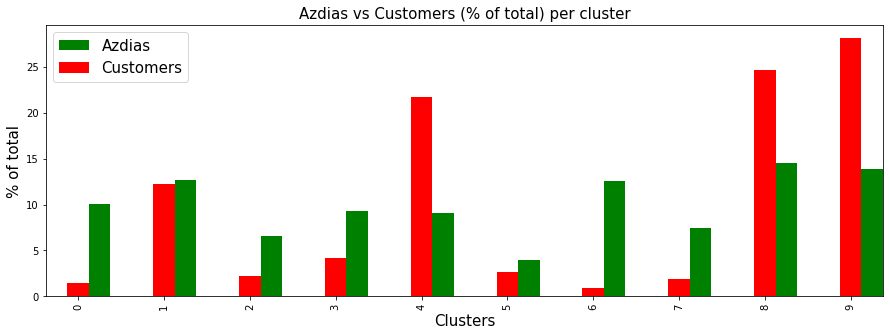

CPU times: user 239 ms, sys: 123 µs, total: 240 ms
Wall time: 236 ms


In [107]:
%%time
## Plot the clusters statistics

fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(111)
ax = clusterStatistics['% of processed Azdias'].plot(x = clusterStatistics.index, kind = 'bar', color = 'g', width = 0.25, align = 'edge', position = 0)
ax = clusterStatistics['% of processed Customers'].plot(kind = 'bar',color = 'r', width = 0.25, align = 'edge', position = 1)
ax.set_xlabel('Clusters', fontsize = 15) 
ax.set_ylabel('% of total', fontsize = 15)

plt.legend(('Azdias', 'Customers'), fontsize = 15)
plt.title(('Azdias vs Customers (% of total) per cluster'), fontsize = 15)
plt.show()

In [108]:
%%time
# What kind of cluster has way more Customers than Azdias as a percentage
# Clusters 4, 8 and 9
# Lets look at cluster 9

clusterCenter_2 = pd.Series(azdiasKnn.cluster_centers_[9])
clusterCenterInverse_2 = round(pd.Series(scaler.inverse_transform(pcaScaledAzdiasN.inverse_transform(clusterCenter_2))))
clusterCenterInverse_2 = clusterCenterInverse_2.to_frame().T
clusterCenterInverse_2.columns = preScalingAzdias.columns
display(clusterCenterInverse_2.T)


,0
ANZ_HAUSHALTE_AKTIV,3.0
ANZ_HH_TITEL,0.0
ANZ_KINDER,0.0
ANZ_PERSONEN,3.0
ANZ_TITEL,0.0
BALLRAUM,5.0
CAMEO_DEUG_2015,4.0
CJT_GESAMTTYP,4.0
D19_BANKEN_ANZ_12,0.0
D19_BANKEN_ANZ_24,0.0


CPU times: user 65 ms, sys: 8.02 ms, total: 73 ms
Wall time: 27.1 ms


In [ ]:
# Looking at the values above, columns that stand out:


In [110]:
%%time
# What kind of cluster has way less Customers than Azdias as a percentage
# Clusters 0, 6 and 7
# Lets look at cluster 6

clusterCenter_4 = pd.Series(azdiasKnn.cluster_centers_[6])
clusterCenterInverse_4 = round(pd.Series(scaler.inverse_transform(pcaScaledAzdiasN.inverse_transform(clusterCenter_4))))
clusterCenterInverse_4 = clusterCenterInverse_4.to_frame().T
clusterCenterInverse_4.columns = preScalingAzdias.columns
display(clusterCenterInverse_4.T)

,0
ANZ_HAUSHALTE_AKTIV,6.0
ANZ_HH_TITEL,0.0
ANZ_KINDER,0.0
ANZ_PERSONEN,1.0
ANZ_TITEL,-0.0
BALLRAUM,5.0
CAMEO_DEUG_2015,5.0
CJT_GESAMTTYP,4.0
D19_BANKEN_ANZ_12,0.0
D19_BANKEN_ANZ_24,0.0


CPU times: user 59.1 ms, sys: 0 ns, total: 59.1 ms
Wall time: 27.1 ms


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')